# Setup Env

In [1]:
!pip install fastai --upgrade -q
from fastai.vision.all import *
# from fastai.callback.cutmix import *

!pip install wwf -q
!pip install timm -q
from wwf.vision.timm import *

# !pip install efficientnet_pytorch -q
# from efficientnet_pytorch import EfficientNet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Import data

In [2]:
path = Path('../input/planets-dataset/planet/planet')

In [3]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]

In [4]:
def get_x(r):
    return path/'train-jpg'/(r['image_name']+'.jpg')

def get_y(r):
    return r['tags'].split()

def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=get_x, 
                       get_y=get_y,
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True,max_warp=0),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [5]:
dls = get_data(300,40)

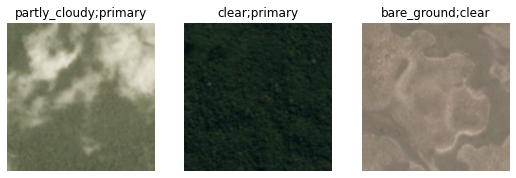

In [6]:
dls.show_batch(nrows=1, ncols=3)

# Training

In [7]:
# f2macro = FBetaMulti(beta=2,average='macro')
# f2micro = FBetaMulti(beta=2,average='micro')
f2samples = FBetaMulti(beta=2,average='samples',thresh=0.2)

# model = EfficientNet.from_pretrained('efficientnet-b7', get_c(dls))
metrics = [partial(accuracy_multi, thresh=0.2), f2samples]
cbs = [MixUp]

In [8]:
# learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs)
# learn = Learner(dls, model, metrics=metrics, f2samples], cbs=cbs)
# learn = Learner(dls, model, metrics=metrics, loss_func=LabelSmoothingCrossEntropy(), cbs=cbs)

learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=cbs)

# learn.lr_find()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [9]:
learn.fine_tune(12, base_lr=3e-2, freeze_epochs=4)

In [10]:
# def f2_score(y_pred, y_true, threshold=0.5, beta=2, eps=1e-9):
#     y_pred = (y_pred > threshold).float()

#     true_positives  = (y_pred * y_true)
#     true_negatives  = ((y_pred + y_true) == 0.).float()
#     false_positives = ((y_pred - y_true) == 1.).float()
#     false_negatives = ((y_true - y_pred) == 1.).float()
    
#     precision = true_positives.sum(dim=1) / ((true_positives + false_positives).sum(dim=1) + eps)
#     recall    = true_positives.sum(dim=1) / ((true_positives + false_negatives).sum(dim=1) + eps)
    
#     score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + eps)

#     return torch.mean(score)

In [11]:
# preds,targs = learn.get_preds()

# xs = torch.linspace(0.05,0.95,29)
# accs = [f2_score(preds, targs, threshold=i) for i in xs]
# plt.plot(xs,accs);

# Submission using TTA

In [12]:
file_path = Path('../input/planets-dataset/test-jpg-additional/test-jpg-additional')
test_path = Path('../input/planets-dataset/planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else file_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [13]:
prediction('submission_tta.csv', tta=True)

image_name                           tags
0         test_0                  clear primary
1         test_1                  clear primary
2         test_2          partly_cloudy primary
3         test_3      agriculture clear primary
4         test_4          partly_cloudy primary
...          ...                            ...
61186  file_9995                         cloudy
61187  file_9996            clear primary water
61188  file_9997       clear primary road water
61189  file_9998                         cloudy
61190  file_9999  clear habitation primary road

[61191 rows x 2 columns]

# Progressive Resizing
not getting good result and take a long time to train

To try: Using a smaller size first then use the 224 size

In [14]:
# dls = get_data(size=448,bs=32)
# learn.dls = dls
# learn.freeze()
# learn.lr_find()

In [15]:
# learn.fine_tune(12, base_lr=3e-3, freeze_epochs=4)

In [16]:
# prediction('submission_tta_2.csv', tta=True)